# Seldon Labs Game Engine

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

In [2]:
class GameNode:
    def __init__(self, player=None, action=None, parent=None, payoffs=None):
        self.player = player        # The player making a decision
        self.action = action        # The action leading to this node
        self.parent = parent        # Parent node (None for root)
        self.children = []          # List of child nodes
        self.payoffs = payoffs      # Payoff tuple (if terminal node)

    def is_terminal(self):
        """Check if this node is a terminal node (has no children)."""
        return len(self.children) == 0

    def add_child(self, action, player, payoffs=None):
        """Add a new child node to this node."""
        child = GameNode(player, action, self, payoffs)
        self.children.append(child)
        return child

In [3]:
class Game:
    def __init__(self, root_player):
        """Initialize the game with a root node (starting player)."""
        self.root = GameNode(player=root_player)
        self.players = {root_player}  # Store players in a set

    def add_moves(self, player, actions):
        """Find all terminal nodes and add new moves (actions) to them."""
        def _recursive_add(node):
            if node.is_terminal():
                node.children = [GameNode(player, action, node) for action in actions]
                self.players.add(player)  # Track players
            else:
                for child in node.children:
                    _recursive_add(child)
        
        _recursive_add(self.root)

    def add_outcomes(self, outcomes):
        """Assign payoffs to all terminal nodes in order."""
        def _assign_outcomes(node, outcome_iter):
            if node.is_terminal():
                node.payoffs = next(outcome_iter)  # Assign payoffs from iterator
            else:
                for child in node.children:
                    _assign_outcomes(child, outcome_iter)

        outcome_iter = iter(outcomes)
        _assign_outcomes(self.root, outcome_iter)

    def get_players(self):
        """Return a sorted list of players in the game."""
        return sorted(self.players)

    def print_tree(self, node=None, level=0):
        """Print the tree structure for visualization."""
        if node is None:
            node = self.root
        indent = "  " * level
        print(f"{indent}- {node.action if node.action else 'Root'} (Player {node.player}, Payoffs: {node.payoffs})")
        for child in node.children:
            self.print_tree(child, level + 1)

    def visualize(self):
        """Generate a graphical representation of the game tree."""
        G = nx.DiGraph()
        labels = {}

        def add_edges(node, parent_name=None, node_id=0):
            """Recursively add edges to the graph."""
            node_name = f"{node.action if node.action else 'Root'}\n({node.player})"
            if node.is_terminal():
                node_name += f"\n{node.payoffs}"  # Show payoffs for terminal nodes
            labels[node_id] = node_name
            G.add_node(node_id)

            if parent_name is not None:
                G.add_edge(parent_name, node_id)

            current_id = node_id
            child_id = node_id + 1
            for child in node.children:
                child_id = add_edges(child, current_id, child_id)
            return child_id

        add_edges(self.root)

        pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="dot")  # Tree layout
        plt.figure(figsize=(10, 6))
        nx.draw(G, pos, with_labels=True, labels=labels, node_size=3000, node_color="lightblue", edge_color="black", font_size=10)
        plt.title("Game Tree Visualization")
        plt.show()

### Solver

In [4]:
class Solver:
    def __init__(self, game):
        """Initialize with a game instance."""
        if not isinstance(game, Game):
            raise TypeError("Solver expects an instance of Game.")
        self.game = game
        self.equilibrium = {}

    def solve(self):
        """Base method to be overridden by specific solvers."""
        raise NotImplementedError("Solve method must be implemented in subclasses.")

    def get_equilibrium(self):
        """Return the computed equilibrium."""
        return self.equilibrium

    # Generalize visualizations

In [5]:
class BackwardInductionSolver(Solver):
    def __init__(self, game):
        """Initialize the backward induction solver with a game."""
        super().__init__(game)
        self.optimal_actions = {}  # Dictionary to store optimal actions at each node
        self.node_values = {}      # Dictionary to store computed values for each node

    def solve(self):
        """Solve the game using backward induction."""
        # Start from the root and solve recursively
        self._backward_induction(self.game.root)           
        return self.optimal_actions

    def _backward_induction(self, node):
        """
        Recursive backward induction algorithm.
        Returns the value (payoff) of the current node.
        """
        # Base case: terminal node
        if node.is_terminal():
            self.node_values[node] = node.payoffs
            return node.payoffs
        
        # Get values of all children
        child_values = []
        for child in node.children:
            child_values.append(self._backward_induction(child))
        # Player makes optimal choice based on their index in the payoff tuple
        player_idx = self.game.get_players().index(node.player)
        # Find the best action for the current player
        best_payoff = float('-inf')
        best_child = None
        
        for i, child in enumerate(node.children):
            player_payoff = self.node_values[child][player_idx]
            if player_payoff > best_payoff:
                best_payoff = player_payoff
                best_child = child
        
        # Store optimal action
        self.optimal_actions[node] = best_child.action
        
        # Set value for current node equal to value of optimal child
        self.node_values[node] = self.node_values[best_child]
        
        return self.node_values[node]
    
    def get_subgame_perfect_equilibrium(self):
        """Return the subgame perfect equilibrium strategies."""
        if not self.node_values:
            self.solve()
        
        # Format the equilibrium strategies by player
        equilibrium = {}
        for player in self.game.get_players():
            equilibrium[player] = {}
        
        # Traverse the tree to determine which nodes are reachable under equilibrium play
        def traverse(node):
            if node in self.optimal_actions:
                # Map each node to the optimal action for that player
                player = node.player
                if node not in equilibrium[player]:
                    equilibrium[player][node] = self.optimal_actions[node]
                
                # Find the child corresponding to the optimal action
                optimal_child = next((child for child in node.children 
                                     if child.action == self.optimal_actions[node]), None)
                
                if optimal_child:
                    traverse(optimal_child)
            
            # For terminal nodes, there's nothing to add
        
        # Start from the root
        traverse(self.game.root)
        
        self.equilibrium = equilibrium
        return equilibrium
    
    def visualize_equilibrium(self):
        """Visualize the game tree with equilibrium strategies highlighted."""
        if not self.equilibrium:
            self.get_subgame_perfect_equilibrium()
        
        import networkx as nx
        import matplotlib.pyplot as plt
        
        G = nx.DiGraph()
        labels = {}
        edge_colors = {}
        
        def add_edges(node, parent_id=None, node_id=0):
            # Create node label
            if node.is_terminal():
                node_label = f"{node.action if node.action else 'Root'}\n({node.player})\nPayoffs: {node.payoffs}"
            else:
                opt_action = self.optimal_actions.get(node, "N/A")
                node_label = f"{node.action if node.action else 'Root'}\n({node.player})\nOptimal: {opt_action}"
            
            labels[node_id] = node_label
            G.add_node(node_id)
            
            if parent_id is not None:
                G.add_edge(parent_id, node_id)
                # Check if this edge is part of the equilibrium path
                if node.parent in self.optimal_actions and self.optimal_actions[node.parent] == node.action:
                    edge_colors[(parent_id, node_id)] = "red"  # Part of equilibrium
                else:
                    edge_colors[(parent_id, node_id)] = "black"  # Not part of equilibrium
            
            current_id = node_id
            next_id = node_id + 1
            
            for child in node.children:
                next_id = add_edges(child, current_id, next_id)
            
            return next_id
        
        add_edges(self.game.root)
        
        pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="dot")
        plt.figure(figsize=(12, 8))
        
        # Draw edges with appropriate colors
        for edge, color in edge_colors.items():
            nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color=color, width=2.0 if color == "red" else 1.0)
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="lightblue")
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
        
        plt.title("Game Tree with Equilibrium Path Highlighted")
        plt.axis("off")
        plt.show()
        
    def print_equilibrium(self):
        """Print the equilibrium strategies in a readable format."""
        if not self.equilibrium:
            self.get_subgame_perfect_equilibrium()
        
        print("Subgame Perfect Equilibrium Strategies:")
        for player, strategies in self.equilibrium.items():
            print(f"Player {player}:")
            for node, action in strategies.items():
                parent_action = node.parent.action if node.parent and node.parent.action else "Root"
                print(f"  After '{parent_action}', choose '{action}'")
        
        print("\nEquilibrium Path and Payoffs:")
        node = self.game.root
        path = ["Root"]
        
        while node and not node.is_terminal():
            if node in self.optimal_actions:
                next_action = self.optimal_actions[node]
                path.append(next_action)
                
                # Find the child with this action
                node = next((child for child in node.children if child.action == next_action), None)
            else:
                break
        
        print(" → ".join(path))
        
        if node and node.is_terminal():
            print(f"Terminal payoffs: {node.payoffs}")

    def record_equilibrium(self): 
        """ Create dictionary of the equilibrium""" 
        if not self.equilibrium:
            self.get_subgame_perfect_equilibrium()

        player_actions = {} 
        for player, strategies in self.equilibrium.items():
            for node, action in strategies.items():
                parent_action = node.parent.action if node.parent and node.parent.action else "Root"
                player_actions[player] = action
        return player_actions

Game Tree Structure:
- Root (Player China, Payoffs: None)
  - Tariff (Player US, Payoffs: None)
    - Tariff (Player US, Payoffs: (-6, -6))
    - No Tariff (Player US, Payoffs: (0, -10))
  - No Tariff (Player US, Payoffs: None)
    - Tariff (Player US, Payoffs: (-10, 0))
    - No Tariff (Player US, Payoffs: (-1, -1))


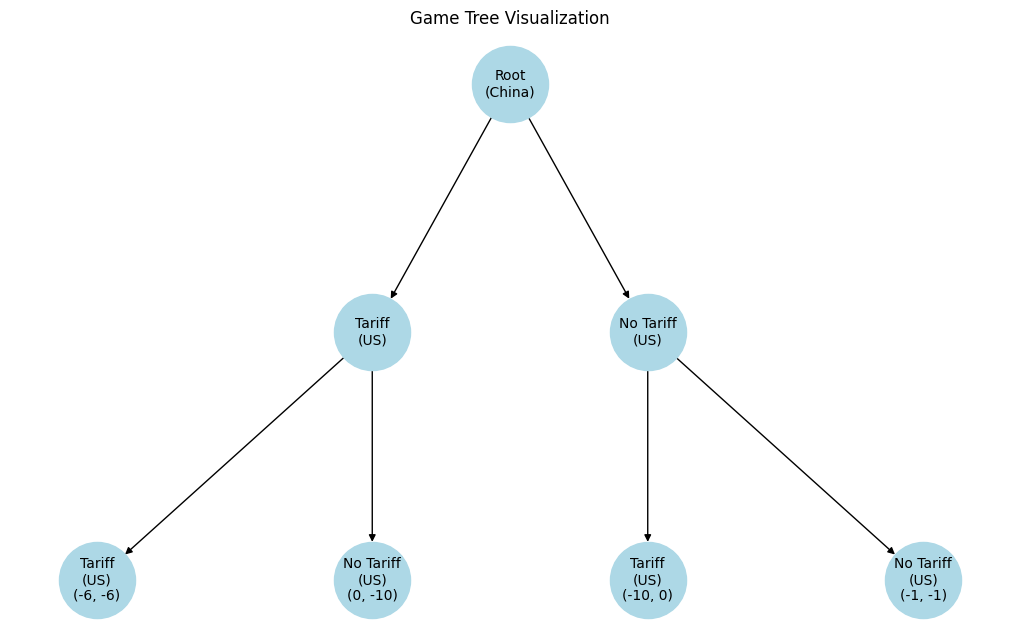


Players in the game: ['China', 'US']


In [13]:
# Create a new game where "China" is the root player
game = Game(root_player="China")

# Add moves: China chooses between "Tariff" or "No Tariff"
game.add_moves(player="US", actions=["Tariff", "No Tariff"])

# Add moves: The US responds to China's move
game.add_moves(player="US", actions=["Tariff", "No Tariff"])

# Define outcomes (payoffs) for all terminal nodes
outcomes = [
    (-6, -6),  # Both impose tariffs
    (0, -10),    # China tariffs, US does not
    (-10, 0),   # China does not tariff, US does
    (-1, -1)    # Neither imposes tariffs
]
game.add_outcomes(outcomes)

# Print the tree structure
print("Game Tree Structure:")
game.print_tree()

# Visualize the game tree
game.visualize()

# Get the players involved in the game
print("\nPlayers in the game:", game.get_players())

## BackwardInductionSolver

In [14]:
# Solve the game
solver = BackwardInductionSolver(game)
solver.solve()
test = solver.record_equilibrium()

Subgame Perfect Equilibrium Strategies:
Player China:
  After 'Root', choose 'Tariff'
Player US:
  After 'Root', choose 'Tariff'

Equilibrium Path and Payoffs:
Root → Tariff → Tariff
Terminal payoffs: (-6, -6)


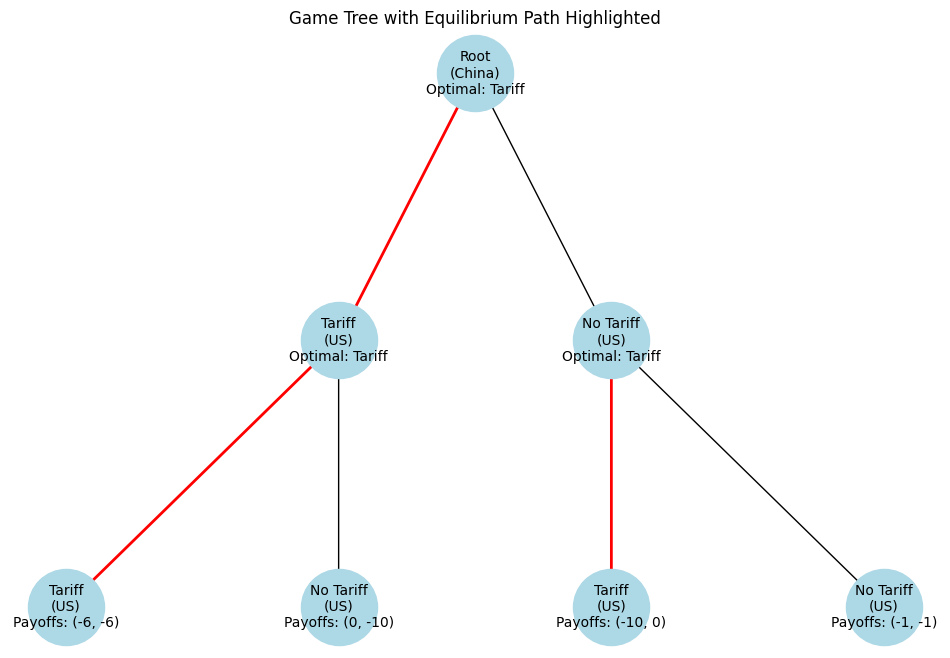

In [15]:
# Display the results
solver.print_equilibrium()
solver.visualize_equilibrium()

## Nash Equilibrium

In [36]:
import numpy as np
from itertools import product

class PureStrategyNashSolver(Solver):
    def __init__(self, game):
        """Initialize the pure strategy Nash equilibrium solver with a game."""
        super().__init__(game)
        self.players = game.get_players()
        self.payoff_matrices = {}  # Player-indexed payoff matrices
        self.pure_equilibria = []
        
    def solve(self):
        """Solve the game to find all pure strategy Nash equilibria."""
        # Convert to normal form first
        self._convert_to_normal_form()
        
        # Find pure strategy equilibria
        self._find_pure_equilibria()
            
        # Format the results
        self._format_equilibrium()
        return self.equilibrium
    
    def _convert_to_normal_form(self):
        """Convert extensive-form game to normal form by generating payoff matrices."""
        # Identify all possible strategies for each player
        player_strategies = self._identify_player_strategies()
        # For each player, create a payoff matrix
        for player in self.players:
            self.payoff_matrices[player] = self._create_payoff_matrix(player, player_strategies)
            
    def _identify_player_strategies(self):
        """
        Identify all possible strategies for each player.
        A strategy is a complete plan of action covering all possible nodes.
        """
        # Dictionary mapping player to their information sets and possible actions
        player_info_sets = {}
        
        # Helper function to traverse the game tree
        def traverse(node):
            if not node.is_terminal():
                player = node.player
                # Track this node and its possible actions
                if player not in player_info_sets:
                    player_info_sets[player] = {}
                
                # Map node to its possible actions
                player_info_sets[player][node] = [child.action for child in node.children]
                
                # Continue traversal
                for child in node.children:
                    traverse(child)
        
        # Start traversal from root
        traverse(self.game.root)
        
        # Generate all possible combinations of actions for each information set
        player_strategies = {}
        for player, info_sets in player_info_sets.items():
            # Get all combinations of actions across all information sets
            action_lists = []
            nodes = []
            for node, actions in info_sets.items():
                nodes.append(node)
                action_lists.append(actions)
            
            # Generate all possible combinations
            all_combinations = list(product(*action_lists))
            
            # Map combinations to strategies (node -> action mappings)
            strategies = []
            for combo in all_combinations:
                strategy = {nodes[i]: combo[i] for i in range(len(nodes))}
                strategies.append(strategy)
                
            player_strategies[player] = strategies
            
        return player_strategies
    
    def _create_payoff_matrix(self, player, player_strategies):
        """
        Create a payoff matrix for the given player.
        """
        # Get dimensions of the payoff matrix
        dimensions = [len(strategies) for p, strategies in player_strategies.items()]
        
        # Create an N-dimensional matrix to store payoffs
        payoff_matrix = np.zeros(dimensions)
        
        # Generate all strategy profiles (combinations of strategies)
        strategy_indices = [range(len(strategies)) for p, strategies in player_strategies.items()]
        player_list = list(player_strategies.keys())
        
        for indices in product(*strategy_indices):
            # Create a strategy profile
            strategy_profile = {}
            for i, player_i in enumerate(player_list):
                strategy_profile[player_i] = player_strategies[player_i][indices[i]]
            
            # Simulate the game with this strategy profile to get outcome
            payoff = self._simulate_outcome(strategy_profile)
            
            # Store the payoff for this player at the corresponding indices
            payoff_index = self.players.index(player)
            payoff_matrix[indices] = payoff[payoff_index]
            
        return payoff_matrix
    
    def _simulate_outcome(self, strategy_profile):
        """
        Simulate the outcome of the game given a strategy profile.
        Returns the payoffs for each player.
        """
        # Start at the root and follow the actions specified in the strategy profile
        node = self.game.root
        
        while not node.is_terminal():
            player = node.player
            # Get the action for this player at this node
            action = strategy_profile[player].get(node)
            
            # Find the child node corresponding to this action
            next_node = next((child for child in node.children if child.action == action), None)
            
            if next_node is None:
                # Strategy profile doesn't specify a valid action, which shouldn't happen
                raise ValueError(f"Invalid strategy profile: no action {action} for player {player} at node {node.action}")
                
            node = next_node
            
        # Return the payoffs at the terminal node
        return node.payoffs
    
    def _find_pure_equilibria(self):
        """Find all pure strategy Nash equilibria."""
        # For simple 2-player games
        if len(self.players) == 2:
            return self._find_2player_pure_equilibria()
        
        # For N-player games, use a more general approach
        player_list = self.players
        strategy_sizes = [self.payoff_matrices[player].shape[i] for i, player in enumerate(player_list)]
        
        # Check each strategy profile
        for indices in product(*[range(size) for size in strategy_sizes]):
            is_equilibrium = True
            
            # Check if any player has a profitable deviation
            for i, player in enumerate(player_list):
                payoff_matrix = self.payoff_matrices[player]
                
                # Player's current payoff
                current_payoff = payoff_matrix[indices]
                
                # Check if player can do better by deviating
                for alt_strat in range(strategy_sizes[i]):
                    if alt_strat == indices[i]:
                        continue  # Skip current strategy
                        
                    # Create new indices with deviation
                    deviation_indices = list(indices)
                    deviation_indices[i] = alt_strat
                    deviation_indices = tuple(deviation_indices)
                    
                    # Check if deviation improves payoff
                    deviation_payoff = payoff_matrix[deviation_indices]
                    if deviation_payoff > current_payoff:
                        is_equilibrium = False
                        break
                
                if not is_equilibrium:
                    break
                    
            if is_equilibrium:
                # Convert indices to strategies
                equilibrium_strategies = {}
                for i, player in enumerate(player_list):
                    player_strat_idx = indices[i]
                    # We need to map back to the actual strategies
                    equilibrium_strategies[player] = player_strat_idx
                    
                self.pure_equilibria.append(equilibrium_strategies)
    
    def _find_2player_pure_equilibria(self):
        """Find pure strategy equilibria for 2-player games."""
        player1, player2 = self.players
        payoff_matrix1 = self.payoff_matrices[player1]
        payoff_matrix2 = self.payoff_matrices[player2]

        print(payoff_matrix1)
        print(payoff_matrix2)
        
        # Get dimensions
        rows, cols = payoff_matrix1.shape
        
        # Find row player's best responses to each column
        col_best_responses = []
        for j in range(cols):
            # Best response to column j
            best_response = np.argmax([payoff_matrix1[i, j] for i in range(rows)])
            col_best_responses.append(best_response)
            
        # Find column player's best responses to each row
        row_best_responses = []
        for i in range(rows):
            # Best response to row i
            best_response = np.argmax([payoff_matrix2[i, j] for j in range(cols)])
            row_best_responses.append(best_response)
            
        # Find cells where best responses match (Nash equilibria)
        for i in range(rows):
            for j in range(cols):
                if col_best_responses[j] == i and row_best_responses[i] == j:
                    # This is a Nash equilibrium
                    equilibrium = {
                        player1: i,  # Strategy index for player 1
                        player2: j   # Strategy index for player 2
                    }
                    self.pure_equilibria.append(equilibrium)
    
    def _format_equilibrium(self):
        """Format equilibria for consistent output."""
        self.equilibrium = self.pure_equilibria
    
    def print_equilibria(self):
        """Print all found pure strategy Nash equilibria in a readable format."""
        if not self.equilibrium:
            self.solve()
            
        print("Pure Strategy Nash Equilibria:")
        
        if self.equilibrium:
            for i, eq in enumerate(self.equilibrium, 1):
                print(f"Equilibrium {i}:")
                for player, strategy_idx in eq.items():
                    print(f"  Player {player}: Strategy {strategy_idx}")
        else:
            print("No pure strategy equilibria found.")
            
    def visualize_equilibria(self):
        """Visualize the normal form game with pure Nash equilibria highlighted."""
        if not self.equilibrium:
            self.solve()
            
        # Check if it's a 2-player game (which is easier to visualize)
        if len(self.players) != 2:
            print("Visualization is only implemented for 2-player games.")
            return
            
        import matplotlib.pyplot as plt
        
        player1, player2 = self.players
        payoff_matrix1 = self.payoff_matrices[player1]
        payoff_matrix2 = self.payoff_matrices[player2]
        
        rows, cols = payoff_matrix1.shape
        
        # Create a new figure
        plt.figure(figsize=(8, 6))
        
        # Create the payoff table
        cell_text = []
        for i in range(rows):
            row = []
            for j in range(cols):
                row.append(f"({payoff_matrix1[i, j]}, {payoff_matrix2[i, j]})")
            cell_text.append(row)
            
        # Highlight cells that are Nash equilibria
        colors = np.zeros((rows, cols, 3))  # RGB
        
        # Mark pure strategy equilibria
        for eq in self.equilibrium:
            i = eq[player1]
            j = eq[player2]
            colors[i, j] = [0.8, 1, 0.8]  # Light green
            
        # Create column and row labels
        col_labels = [f"Strategy {j}" for j in range(cols)]
        row_labels = [f"Strategy {i}" for i in range(rows)]
        
        # Add a table at the specified position
        table = plt.table(cellText=cell_text,
                        rowLabels=row_labels,
                        colLabels=col_labels,
                        cellColours=colors,
                        loc='center')
        
        # Adjust table properties
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.2)
        
        # Hide axes
        plt.axis('off')
        
        # Set title
        plt.title("Normal Form Game with Pure Strategy Nash Equilibria")
        
        # Add a legend
        import matplotlib.patches as mpatches
        green_patch = mpatches.Patch(color=[0.8, 1, 0.8], label='Pure Strategy Nash Equilibrium')
        plt.legend(handles=[green_patch], loc='upper right')
        
        plt.tight_layout()
        plt.show()

In [37]:
solver = PureStrategyNashSolver(game)
solver.solve()

[[ -6.  -6.   0.   0.]
 [-10.  -1. -10.  -1.]]
[[ -6.  -6. -10. -10.]
 [  0.  -1.   0.  -1.]]


[{'China': 0, 'US': 0}]

In [38]:
solver.print_equilibria() 

Pure Strategy Nash Equilibria:
Equilibrium 1:
  Player China: Strategy 0
  Player US: Strategy 0


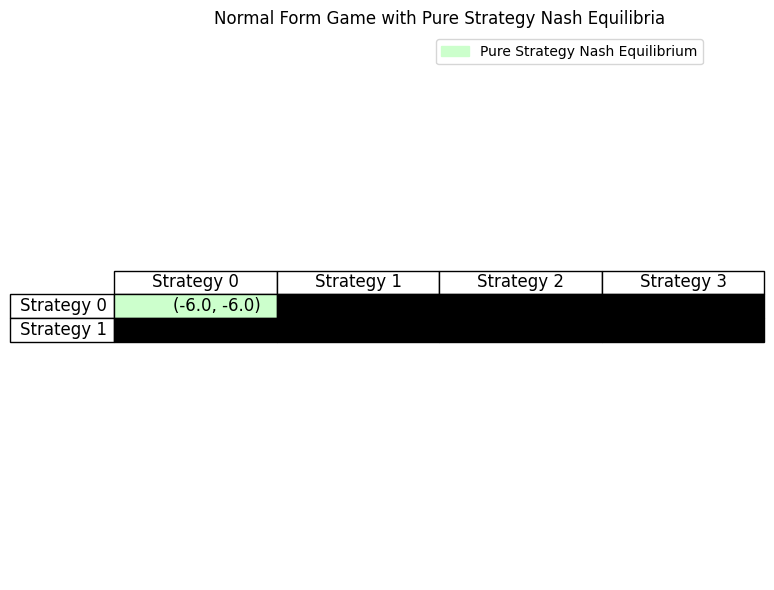

In [39]:
solver.visualize_equilibria()

In [40]:
# Switching player order

In [41]:
#Signaling